### Optimisation of positioning of the turbine
This notebook will look to optimise the positioning of the turbine to provide maximum power output allowing for variation in position (and eventually RPM, and other design parameters)

In [1]:
import scipy.optimize as opt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from breastshot_calcs import breastTurbine
from river_class import river_obj
from undershot_calcs import underTurbine


In [2]:
# define a generic river object
river = river_obj(0.7, 0.3, 1.5)

# define the turbine
radius = 0.504
width = 1.008
num_blades = 5
# x_centre = 0
# y_centre = 0

x_offset, y_offset = 0.5939999999999996,1.0859999999999905

turbine = breastTurbine(radius,width, num_blades, 0, 0, river)

# first define the function to be optimised
def fun(Y):
    # unpack the variables
    x, y = Y
    # define the power
    power = turbine.analysis(x , y  , RPM = 15)
    
    return -power

# define the bounds of the optimisation
bounds = [(-1,-1), (4,4)]

# define the initial guess
x0 = [1, -0.2]

# run the optimisation
res = opt.fmin(fun, x0 )
# newx, newy = res.allvecs[-1]

# print the results
newx, newy = res
print('The optimal position is: ({}, {})'.format(newx, newy))

# reinstantiate the turbine
turbine = breastTurbine(radius, width, num_blades, newx, newy, river)




Optimization terminated successfully.
         Current function value: -489.622576
         Iterations: 97
         Function evaluations: 180
The optimal position is: (0.8990377409699798, -0.24195239840885738)


(-1.0, 1.0)

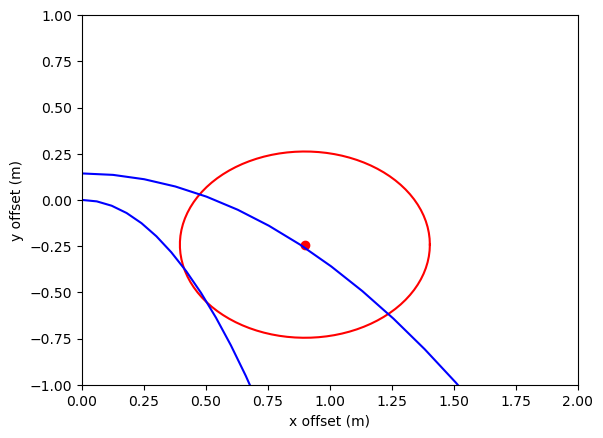

In [3]:
# plot the results - the turbine is in red
plt.plot(turbine.x_centre , turbine.y_centre, 'ro')
plt.plot(turbine.x, turbine.y, 'r')

# plot the river
plt.plot(river.x_nappe,river.y_nappe, 'b')
plt.plot(river.x_bed,river.y_bed, 'b')

# axis labels
plt.xlabel('x offset (m)')
plt.ylabel('y offset (m)')

plt.xlim(0,2)
plt.ylim(-1,1)



Breast shot turbine average power:  459.5165617577533 W


Text(0, 0.5, 'Output power [W]')

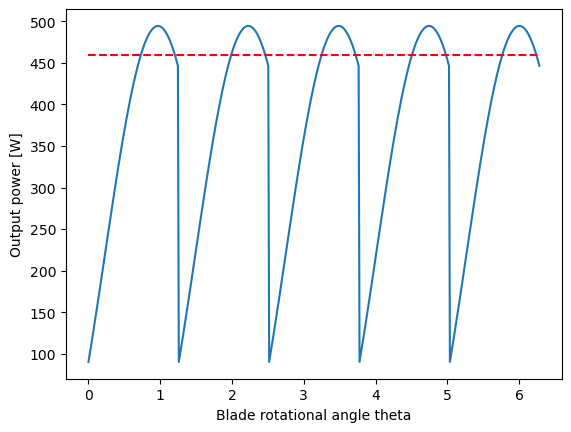

In [4]:
# show the performance of the turbine
turbine.analysis(newx, newy , RPM = 15)

# plot the power vs. theta
plt.plot(turbine.avg_power_angle, turbine.avg_power_list)

print('Breast shot turbine average power: ', turbine.avg_power, 'W')
# plot average power for line
plt.plot([turbine.avg_power_angle[0], turbine.avg_power_angle[-1]], [turbine.avg_power, turbine.avg_power], 'r--')

plt.xlabel('Blade rotational angle theta')
plt.ylabel('Output power [W]')
# plt.title('Output power vs. blade rotational angle for Breastshot turbine')



In [5]:
# find the correlation between river parameters and power
# define the river parameters
river_width = [0.4, 0.6 , 0.8, 1.0, 1.2]
river_depth = [0.3, 0.5, 0.7, 0.9, 1.1]
river_velocity = [0.5, 1.0, 1.5, 2.0, 2.5]

# define the turbine parameters
radius = 0.504
width = 1.008
num_blades = 5
x_centre = 0
y_centre = 0

# define the turbine
turbine = breastTurbine(radius, width, num_blades, x_centre, y_centre, river)

power_mat = []


# loop through the river parameters and optimise for each
for i in range(len(river_width)):
    for j in range(len(river_depth)):
        for k in range(len(river_velocity)):
            # define the river
            river = river_obj(river_width[i], river_depth[j], river_velocity[k])
            # optimise the turbine
            try:
                turbine = breastTurbine(radius, width, num_blades, x_centre, y_centre, river)
                rpm = turbine.find_RPM()
                power, x, y = turbine.optimise( RPM = rpm)
                # calculate the rpm
                
            except:
                power = 0
            # store the power
            power_mat.append([i,j,k,power])
            





/Users/philblecher/Desktop/Github/DP4-code/breastshot_calcs.py:177: RuntimeWarning: invalid value encountered in double_scalars
  flow_velocity = ((self.river.velocity)**2 + (self.g * fall_height * 2))**0.5


Optimization terminated successfully.
         Current function value: -0.432199
         Iterations: 134
         Function evaluations: 245
Optimization terminated successfully.
         Current function value: -0.752446
         Iterations: 85
         Function evaluations: 170
Optimization terminated successfully.
         Current function value: -0.926081
         Iterations: 82
         Function evaluations: 153
Optimization terminated successfully.
         Current function value: -1.175147
         Iterations: 60
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: -0.644162
         Iterations: 108
         Function evaluations: 210
Optimization terminated successfully.
         Current function value: -0.925475
         Iterations: 82
         Function evaluations: 159
Optimization terminated successfully.
         Current function value: -1.229947
         Iterations: 87
         Function evaluations: 169
Optimization termi

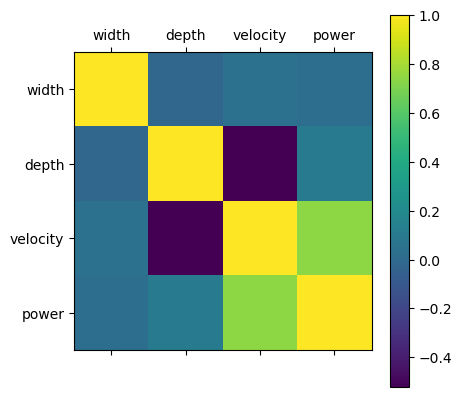

In [6]:
# make power_mat into a dataframe
power_df = pd.DataFrame(power_mat, columns = ['width', 'depth', 'velocity', 'power'])

# remove rows with zero power
power_df = power_df[power_df['power'] != 0]

# make correlation matrix
corr = power_df.corr()

# plot the correlation matrix
plt.matshow(corr)
plt.xticks(range(len(corr.columns)), corr.columns)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()
plt.show()


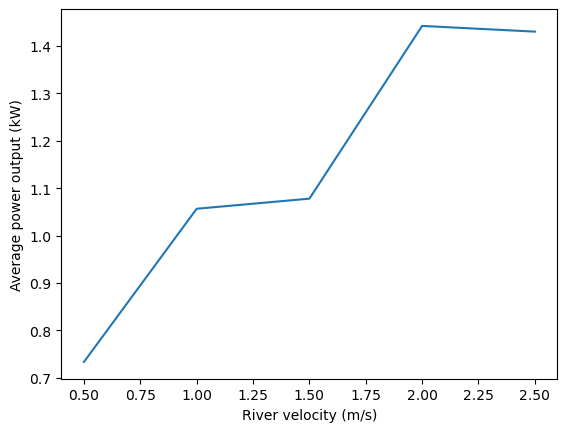

In [7]:


# plot the power vs. river velocity
plt.plot(river_velocity, power_df.groupby('velocity').mean()['power'])
plt.xlabel('River velocity (m/s)')
plt.ylabel('Average power output (kW)')
plt.show()


In [8]:
# demonstrate the impact of varying RPM on power output

rpms = np.linspace(5, 50, 10)
power_list = []

radius = 0.504
width = 1.008
num_blades = 5
x_centre = 0
y_centre = 0
river = river_obj(0.7, 0.3, 1.5)

# initialise the turbine
turbine = breastTurbine(radius, width, num_blades, x_centre, y_centre, river)

# optimise the turbine
power, x, y = turbine.optimise( RPM = 15)

# loop through the rpms


for rpm in rpms:

    power_list.append(turbine.analysis(x, y, RPM = rpm))



Optimization terminated successfully.
         Current function value: -489.622576
         Iterations: 97
         Function evaluations: 180


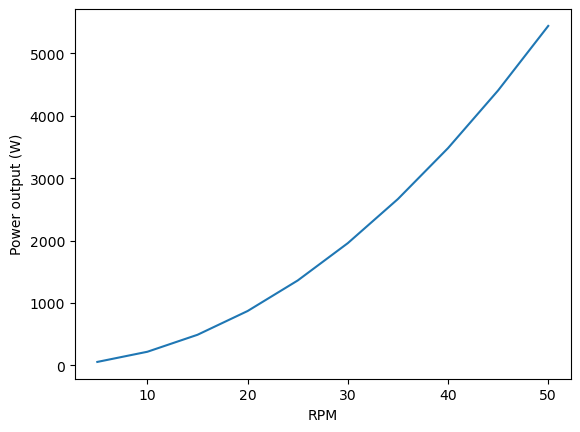

In [9]:
# plot the results
plt.plot(rpms, power_list )
plt.xlabel('RPM')
plt.ylabel('Power output (W)')
plt.show()


  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: -3448.2700788823136
        x: [-1.000e-01]
      nit: 0
      jac: [ 0.000e+00]
     nfev: 2
     njev: 1
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>


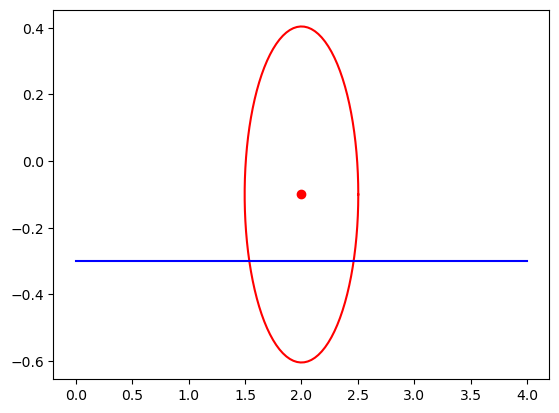

In [7]:
# define a generic river object
river = river_obj(0.7, 0.3, 3)

# define the turbine
radius = 0.504
width = 1.008
num_blades = 5
# x_centre = 0
# y_centre = 0

under_turbine = underTurbine(radius,width, num_blades, 0.3, river)

# first define the function to be optimised
def fun(y):
    # define the power
    power = under_turbine.analysis(y , RPM = 15)
    
    return -power

# max depth
max_depth = -river.depth + radius

# run the optimisation
res = opt.minimize(fun, -0.1, bounds = [(-1, 3)])

print(res)

# newx, newy = res.allvecs[-1]

# reinstantiate the turbine
under_turbine = underTurbine(radius, width, num_blades, res.x, river)

# plot the results - the turbine is in red
plt.plot(under_turbine.x_centre, under_turbine.y_centre, 'ro')
plt.plot(under_turbine.x, under_turbine.y, 'r')

# plot the river as line at -river.depth
plt.plot([-0,4], [-river.depth, -river.depth], 'b')




